# Ejercicio para RNN



Empleando el notebook de [predicción de serie temporal](jupyter_notebooks/RNN_signal_TP.ipynb), proponer una 
arquitectura de RNN que mejore la performance del MLP.
 Deberá contar con las siguientes características:

- Largo de entrada 50 muestras (para pasarle el mismo número de datos que al MLP).
- Predicción a futuro 10 muestras.
- Emplear el mismo paquete de datos generados (con la función `generate_time_series`) para
contar con los exactos mismos datos de entrenamiento, validación y testeo.
- Recordar que el MLP está programado para predecir 1 solo valor a futuro y
ahora deseamos predecir 10 valores a futuro!

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

In [4]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X

In [5]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            #print(X.shape)
            #input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            #print('y shape')
            #print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            #print(y.shape)
            #print(' y hat shape')
            #print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [6]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

### Creamos nuestro dataset 

X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


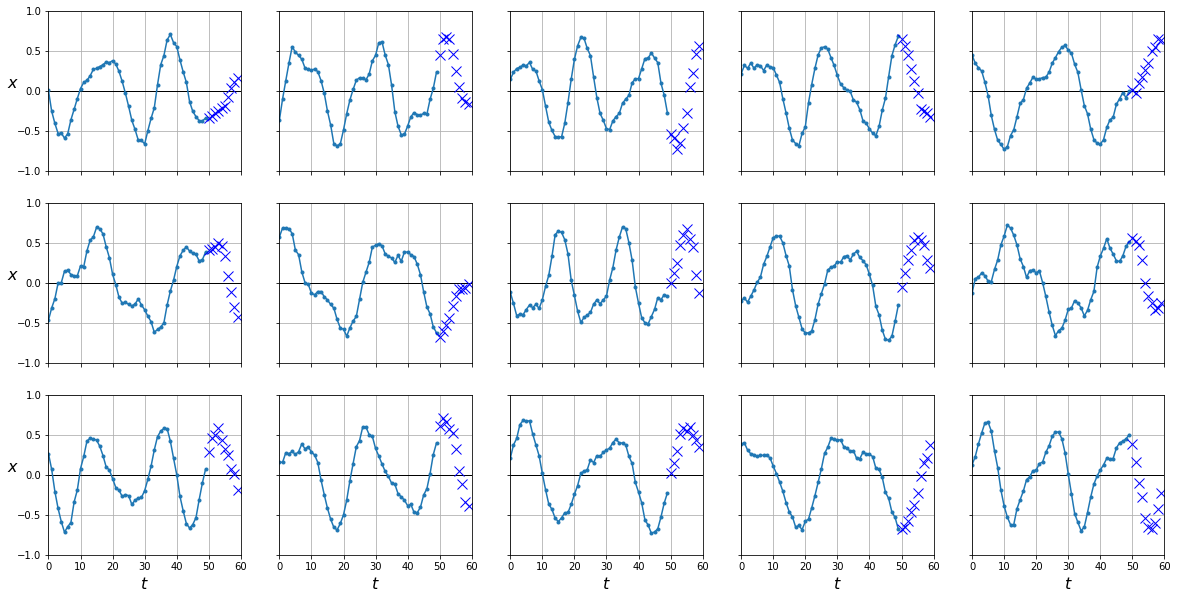

In [10]:
n_steps = 50
n_future = 10
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)
plot_series(X_test, y_test)

In [11]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

### Hago un modelo base para luego poder comparar

In [12]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=10, bias=True)
)

In [13]:
fit(mlp, dataloader)

epoch numero:  0


valid_loss 0.06821: 100%|██████████| 32/32 [00:00<00:00, 189.15it/s]


epoch numero:  1


valid_loss 0.05021: 100%|██████████| 32/32 [00:00<00:00, 366.33it/s]


epoch numero:  2


valid_loss 0.04155: 100%|██████████| 32/32 [00:00<00:00, 405.08it/s]


epoch numero:  3


valid_loss 0.03659: 100%|██████████| 32/32 [00:00<00:00, 396.38it/s]


epoch numero:  4


valid_loss 0.03319: 100%|██████████| 32/32 [00:00<00:00, 252.38it/s]


epoch numero:  5


valid_loss 0.03072: 100%|██████████| 32/32 [00:00<00:00, 326.32it/s]


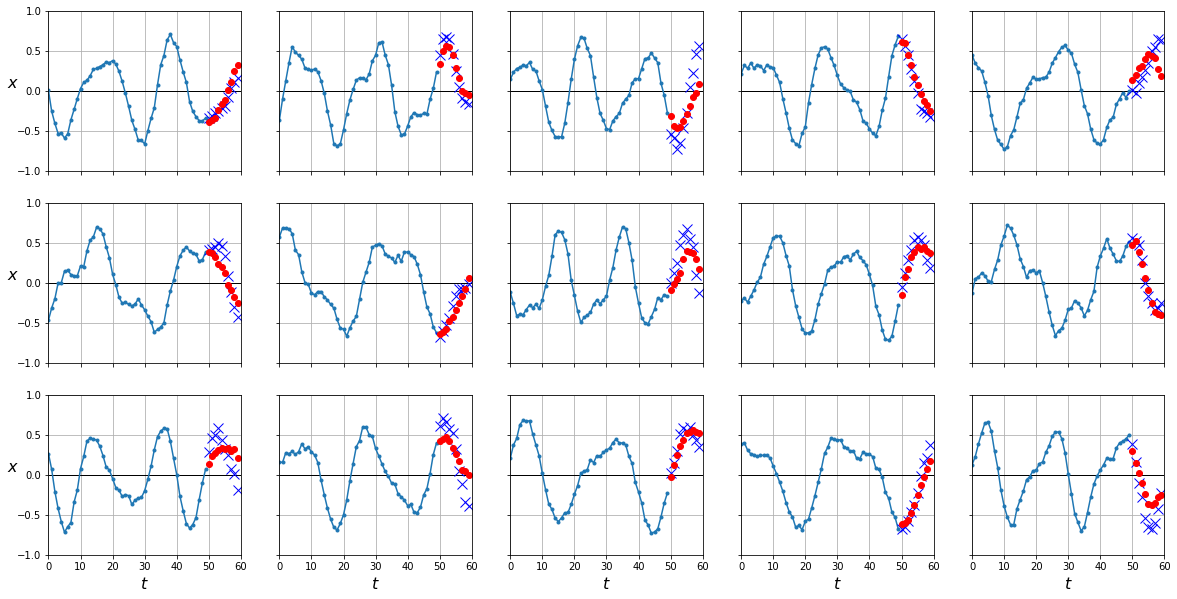

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.030916309

In [14]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

### Probamos con RNN de una sola neurona

In [26]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(1,10)
  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    # solo queremos las últimas 10 salidas
    return y
    #return x[:,-1:,-1]

rnn = SimpleRNN()
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.4209, 0.9786, 0.3761, 0.4314, 0.2455, 0.5170, 0.1068, 0.5771, 0.6119,
        0.0309, 0.9321, 0.7456, 0.2870, 0.3511, 0.6723, 0.0951, 0.4001, 0.2677,
        0.2168, 0.2779, 0.4222, 0.0621, 0.3560, 0.6390, 0.7537, 0.1129, 0.1742,
        0.2023, 0.1788, 0.3908, 0.8180, 0.4033, 0.7898, 0.4921, 0.6969, 0.5280,
        0.3921, 0.4624, 0.0500, 0.5513, 0.6135, 0.7816, 0.3338, 0.2060, 0.7574,
        0.5305, 0.2334, 0.1878, 0.9179, 0.2106])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [27]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[ 0.1090,  0.9875,  0.7937, -0.1059, -1.0417, -1.2079,  0.0248,  1.3689,
          0.4278,  0.2219]], grad_fn=<AddmmBackward0>)
salida shape:
torch.Size([1, 10])


In [28]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como input:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como input:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 10, 1])


In [29]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.51600: 100%|██████████| 32/32 [00:00<00:00, 179.93it/s]


epoch numero:  1


valid_loss 0.33457: 100%|██████████| 32/32 [00:00<00:00, 183.76it/s]


epoch numero:  2


valid_loss 0.24048: 100%|██████████| 32/32 [00:00<00:00, 182.76it/s]


epoch numero:  3


valid_loss 0.19107: 100%|██████████| 32/32 [00:00<00:00, 177.05it/s]


epoch numero:  4


valid_loss 0.16593: 100%|██████████| 32/32 [00:00<00:00, 160.58it/s]


epoch numero:  5


valid_loss 0.15290: 100%|██████████| 32/32 [00:00<00:00, 163.82it/s]


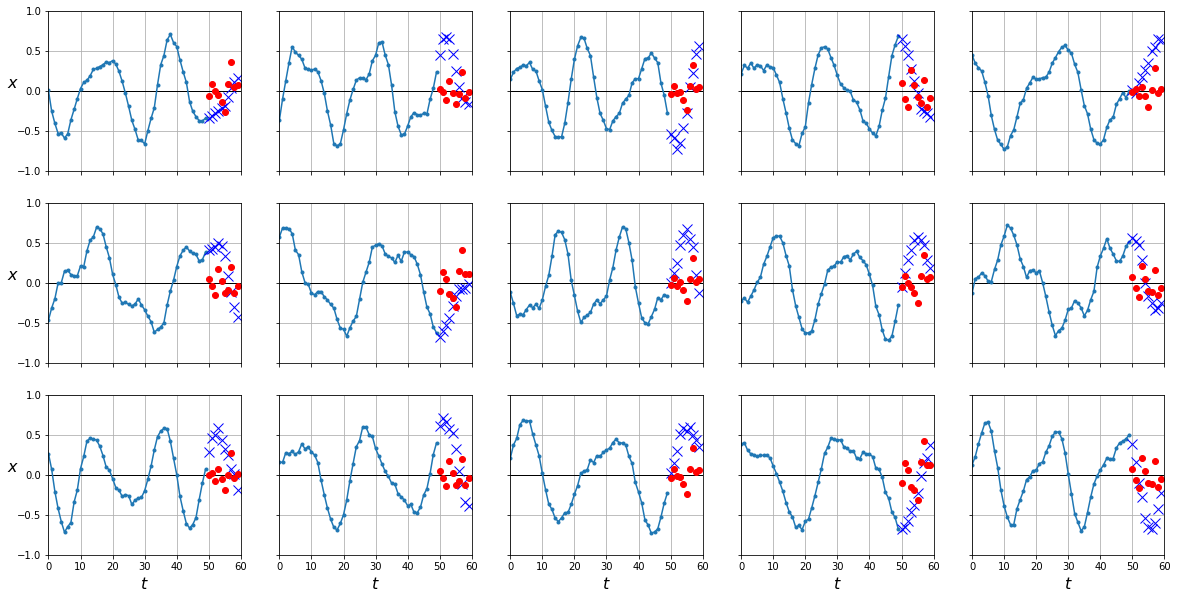

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.15359291

In [30]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

#### Obeservamos del resultado anterior que el modelo RNN de una sola neurona performa mucho peor que el modelo MLP
## Probamos ahora con un modelo mas complejo de RNN

In [32]:
class RNN20(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    #print(x.shape)
    #print('x shape [:,-1:]')
    #print(x[:,-1:].shape)
    y = self.fc(x[:,-1])
    
    return y

rnn_2 = RNN20()

# parámetros en el RNN
imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([10, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([10])



In [34]:
# Entrenamos nuestro nuevo modelo de 20 capas

fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.05379: 100%|██████████| 32/32 [00:00<00:00, 151.79it/s]


epoch numero:  1


valid_loss 0.04491: 100%|██████████| 32/32 [00:00<00:00, 150.17it/s]


epoch numero:  2


valid_loss 0.04202: 100%|██████████| 32/32 [00:00<00:00, 144.68it/s]


epoch numero:  3


valid_loss 0.04023: 100%|██████████| 32/32 [00:00<00:00, 132.44it/s]


epoch numero:  4


valid_loss 0.03709: 100%|██████████| 32/32 [00:00<00:00, 147.15it/s]


epoch numero:  5


valid_loss 0.03552: 100%|██████████| 32/32 [00:00<00:00, 138.84it/s]


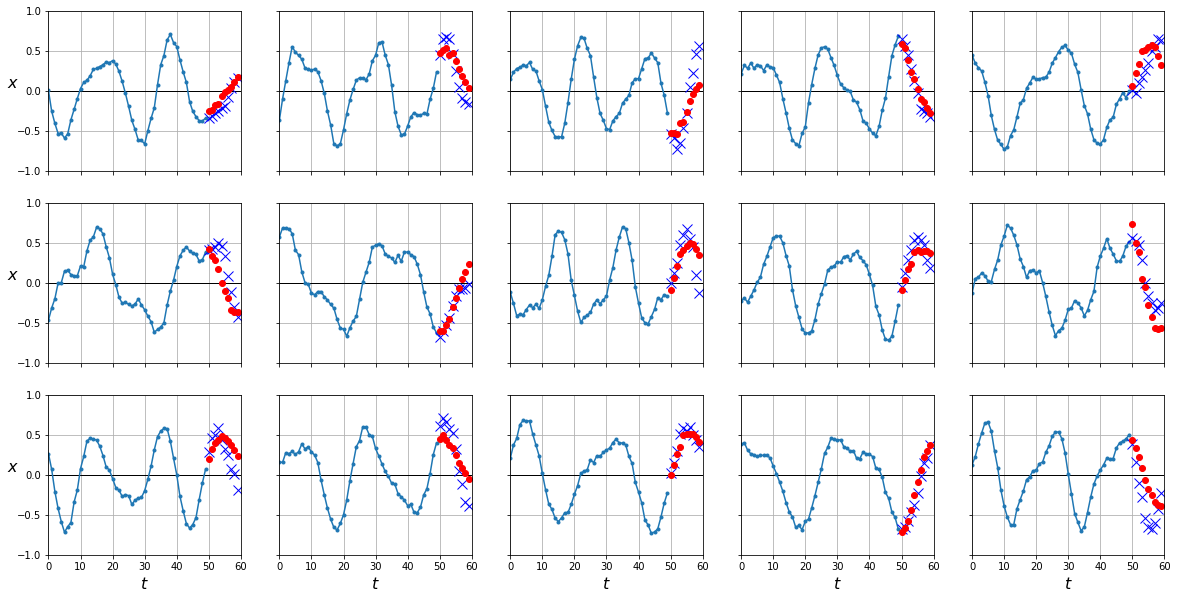

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.03673277

In [35]:
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

#### Obeservamos del resultado anterior que el modelo RNN de 20 filtros ocultos performa casi igual, levemente peor, que el primer modelo MLP de una capa
## Probamos nuevamente con un modelo mas complejo aún de RNN (dos capas de 40 filtros hidden cada una)

In [36]:
class RNN40(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=40, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(40, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    #print(x.shape)
    #print('x shape [:,-1:]')
    #print(x[:,-1:].shape)
    y = self.fc(x[:,-1])
    
    return y

rnn_3 = RNN40()

# parámetros en el RNN
imp_param(rnn_3)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([40, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([40, 40])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([40])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([40])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([40, 40])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([40, 40])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([40])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([40])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([10, 40])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([10])



In [37]:
# Entrenamos nuestro nuevo modelo de 20 capas

fit(rnn_3, dataloader)

epoch numero:  0


valid_loss 0.03955: 100%|██████████| 32/32 [00:00<00:00, 107.48it/s]


epoch numero:  1


valid_loss 0.03251: 100%|██████████| 32/32 [00:00<00:00, 106.59it/s]


epoch numero:  2


valid_loss 0.02664: 100%|██████████| 32/32 [00:00<00:00, 104.24it/s]


epoch numero:  3


valid_loss 0.02342: 100%|██████████| 32/32 [00:00<00:00, 109.90it/s]


epoch numero:  4


valid_loss 0.01497: 100%|██████████| 32/32 [00:00<00:00, 89.71it/s]


epoch numero:  5


valid_loss 0.01429: 100%|██████████| 32/32 [00:00<00:00, 105.80it/s]


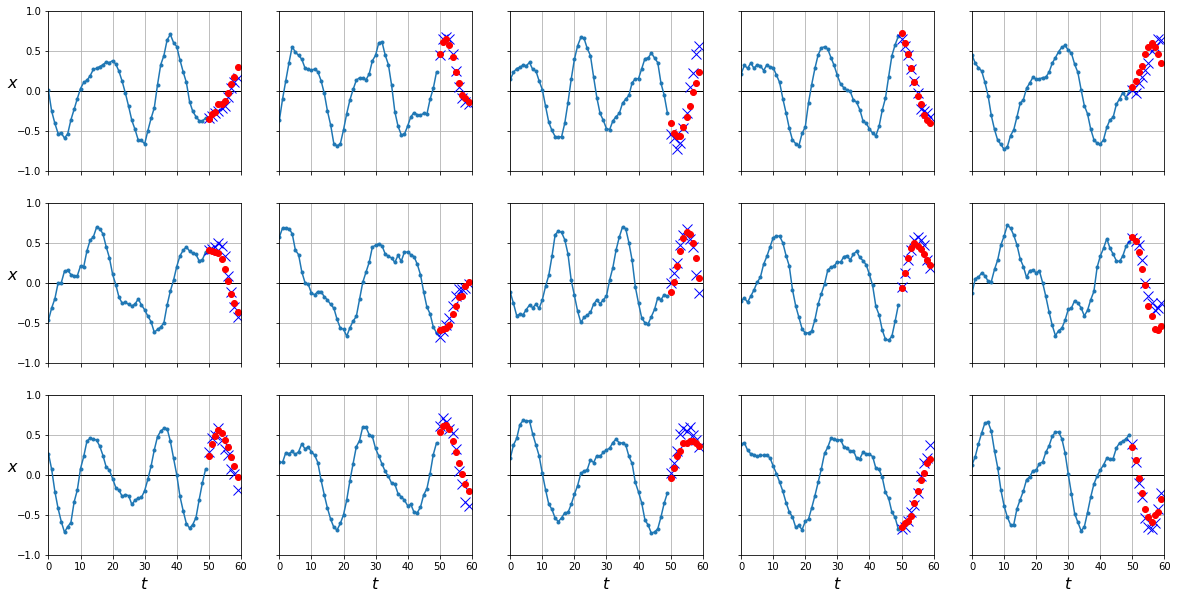

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.013809619

In [38]:
y_pred = predict(rnn_3, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## FINALMENTE VEMOS QUE LA PERFORMANCE (MSE = 0.013) ES MUCHO MEJOR QUE EN TODOS LOS MODELOS ANTERIORES!!